# Bayesian Optimization

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
from skgarden import RandomForestQuantileRegressor
from depimpact.plots import set_style_paper
from skopt import forest_minimize
from skopt.acquisition import gaussian_ei, gaussian_lcb, gaussian_pi

%matplotlib inline
%load_ext autoreload
%autoreload 2
set_style_paper()

## The stochastic function

In [2]:
from scipy.special import erfinv
def func(X, noise_lvl=0.2, nu=1., return_quantile=False, type_noise='uniform', alpha=0.05):
    """
    """
    X = np.asarray(X)
    n_sample = X.shape[0]
    if type_noise == 'uniform':
        noise = np.random.uniform(-noise_lvl, noise_lvl, n_sample)
    elif type_noise == 'normal':
        noise = np.random.normal(0., noise_lvl, n_sample)
    else:
        raise ValueError('Wrong type_noise')
        
    y = X*np.cos(2*np.pi*X) + (X-nu)**2*noise
    if return_quantile:
        if type_noise == 'uniform':
            q = 2*noise_lvl*alpha - noise_lvl
        elif type_noise == 'normal':
            q = noise_lvl*np.sqrt(2)*erfinv * (2*alpha - 1)
            
        quantile = X*np.cos(2*np.pi*X) + (X-nu)**2*q 
        if n_sample == 1:
            return y.item(), quantile.item()
        else:
            return y, quantile
    else:
        if n_sample == 1:
            return y.item()
        else:
            return y

### Illustration

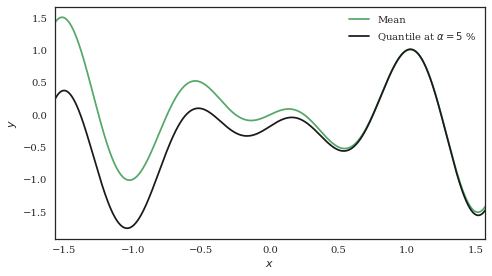

In [3]:
xmin, xmax = -np.pi/2, np.pi/2.

def plot_func(func, xmin, xmax, n_plot=100000, alpha=0.05, ax=None):
    x_plot = np.linspace(xmin, xmax, n_plot)
    y_true = func(x_plot, noise_lvl=0.)
    y_noised, quant = func(x_plot, return_quantile=True, alpha=alpha)
    id_min_true = y_true.argmin()
    id_min_noised = quant.argmin()

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(x_plot, y_true, 'g-', label='Mean')
    ax.plot(x_plot, quant, 'k-', label='Quantile at $\\alpha=%d$ %%' % (alpha*100))
    #ax.plot(x_plot[id_min_true], y_true[id_min_true], 'go', label='Excepted min')
    #ax.plot(x_plot[id_min_noised], quant[id_min_noised], 'ro', label='Quantile min')
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('$x$')    
    ax.set_ylabel('$y$')
    return ax

fig, ax = plt.subplots(figsize=(7, 4))
plot_func(func, xmin, xmax, ax=ax)
ax.legend(loc=0)
fig.tight_layout()

## Optimization

In [4]:
class ModifiedRandomForestQuantileRegressor(RandomForestQuantileRegressor):
    def predict(self, X, return_std=False):
        """
        """
        X = np.asarray(X)
        alpha = 0.05
        if return_std:
            n_sample = X.shape[0]
            n_estimators = self.n_estimators
            pred = np.zeros((n_estimators, n_sample))
            for i, tree in enumerate(self.estimators_):
                pred[i] = tree.predict(X, quantile=alpha*100)

            mean = pred.mean(axis=0)
            std = pred.std(axis=0)
            return mean, std
        else:
            mean = RandomForestQuantileRegressor.predict(self, X, quantile=alpha*100)
            return mean

In [5]:
n_random_starts = 50
n_iter = 100
n_estimators = 200
min_samples_split = max(2, int(n_random_starts/10))
rfq = ModifiedRandomForestQuantileRegressor(n_estimators, min_samples_split=min_samples_split, n_jobs=7)
n_calls = n_random_start + n_iter
space = [(xmin, xmax)]
acq_func = 'EI'

opt_res = forest_minimize(func, space, acq_func=acq_func, base_estimator=rfq,
                      n_calls=n_calls, n_random_starts=n_random_starts, n_jobs=7, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0011
Function value obtained: -1.4609
Current minimum: -1.4609
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: 0.0731
Current minimum: -1.4609
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: 1.0099
Current minimum: -1.4609
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: 0.7427
Current minimum: -1.4609
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: -1.4953
Current minimum: -1.4953
Iteration No: 6 started. Eva

Iteration No: 50 ended. Evaluation done at random point.
Time taken: 1.1746
Function value obtained: 0.6548
Current minimum: -1.4953
Iteration No: 51 started. Searching for the next optimal point.
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 1.3088
Function value obtained: -0.9089
Current minimum: -1.4953
Iteration No: 52 started. Searching for the next optimal point.
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 1.1791
Function value obtained: -0.5852
Current minimum: -1.4953
Iteration No: 53 started. Searching for the next optimal point.
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.2678
Function value obtained: -0.8282
Current minimum: -1.4953
Iteration No: 54 started. Searching for the next optimal point.
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 1.2837
Function value obtained: 0.0303
Current minimum: -1.4953
Iteration No: 55 started. Search

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.5209
Function value obtained: -1.1396
Current minimum: -1.6533
Iteration No: 91 started. Searching for the next optimal point.
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.4143
Function value obtained: -1.1935
Current minimum: -1.6533
Iteration No: 92 started. Searching for the next optimal point.
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.4269
Function value obtained: -1.2097
Current minimum: -1.6533
Iteration No: 93 started. Searching for the next optimal point.
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.5254
Function value obtained: -1.1508
Current minimum: -1.6533
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.5658
Function value obtained: -0.7128
Current minimum: -1.6533
Iteration No: 95 st

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 1.5744
Function value obtained: -0.6327
Current minimum: -1.6533
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 1.7819
Function value obtained: -0.1575
Current minimum: -1.6533
Iteration No: 131 started. Searching for the next optimal point.
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 1.7126
Function value obtained: -1.2646
Current minimum: -1.6533
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 1.7569
Function value obtained: -1.6477
Current minimum: -1.6533
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 1.6262
Function value obtained: -0.4861
Current minimum: -1.6533
Iteration 

Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 1.8028
Function value obtained: -0.7863
Current minimum: -1.6843
Iteration No: 169 started. Searching for the next optimal point.
Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 1.7456
Function value obtained: -0.5784
Current minimum: -1.6843
Iteration No: 170 started. Searching for the next optimal point.
Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 1.8006
Function value obtained: -0.5683
Current minimum: -1.6843
Iteration No: 171 started. Searching for the next optimal point.
Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 1.8228
Function value obtained: -1.3717
Current minimum: -1.6843
Iteration No: 172 started. Searching for the next optimal point.
Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 1.7086
Function value obtained: -1.2707
Current minimum: -1.6843
Iteration 

Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 1.9844
Function value obtained: -0.8694
Current minimum: -1.6843
Iteration No: 208 started. Searching for the next optimal point.
Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 1.9928
Function value obtained: -0.6099
Current minimum: -1.6843
Iteration No: 209 started. Searching for the next optimal point.
Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 1.9868
Function value obtained: -0.7559
Current minimum: -1.6843
Iteration No: 210 started. Searching for the next optimal point.
Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 1.8957
Function value obtained: -1.6035
Current minimum: -1.6843
Iteration No: 211 started. Searching for the next optimal point.
Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 1.9136
Function value obtained: -1.2053
Current minimum: -1.6843
Iteration 

Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 2.1600
Function value obtained: -0.9801
Current minimum: -1.6843
Iteration No: 247 started. Searching for the next optimal point.
Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 2.1431
Function value obtained: -1.5436
Current minimum: -1.6843
Iteration No: 248 started. Searching for the next optimal point.
Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 2.0488
Function value obtained: -0.5629
Current minimum: -1.6843
Iteration No: 249 started. Searching for the next optimal point.
Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 2.1159
Function value obtained: -0.1949
Current minimum: -1.6843
Iteration No: 250 started. Searching for the next optimal point.
Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 2.1115
Function value obtained: -0.1387
Current minimum: -1.6843


### Results

In [6]:
x = opt_res.x_iters
y = opt_res.func_vals
x_random_start = x[:n_random_start]
y_random_start = y[:n_random_start]

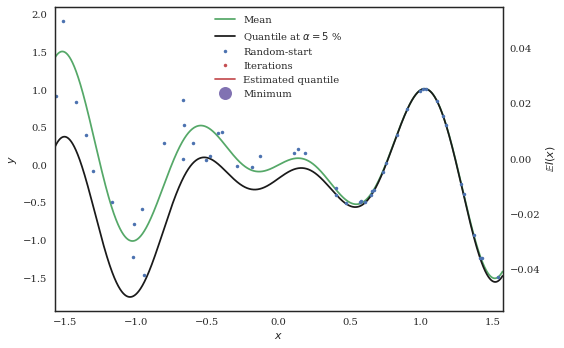

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_func(func, xmin, xmax, ax=ax)
ax2 = ax.twinx()
ax2.set_ylabel("$\mathbb{E}I(x)$")
ax.plot(x_random_start, y_random_start, 'b.', label='Random-start')

def init():
    line_acq, = ax2.plot([], [], "y", label="$\mathbb{E}I(x)$")
    line_iter, = ax.plot([], [], 'r.', label='Iterations')
    line_quant, = ax.plot([], [], 'r-', label='Estimated quantile')
    line_min, = ax.plot([], [], 'mo', markersize=13, label='Minimum')
    return (line_acq, line_iter, line_quant, line_min, )

line_acq, line_iter, line_quant, line_min = init()

ax.legend(loc=0)
fig.tight_layout()

In [8]:
x_plot = np.linspace(xmin, xmax, 100)

def animate(i):
    model_i = opt_res.models[i]
    q_i = model_i.predict(x_plot[:, np.newaxis])
    acq = gaussian_ei(x_plot[:, np.newaxis], model_i, y_opt=np.min(q_i))
    x_iter = x[n_random_start:n_random_start+i+1]
    y_iter = y[n_random_start:n_random_start+i+1]
    id_min = q_i.argmin()
    x_min = x_plot[id_min]
    q_min = q_i[id_min]
    
    line_acq.set_data(x_plot, acq)
    line_iter.set_data(x_iter, y_iter)
    line_quant.set_data(x_plot, q_i)
    line_min.set_data(x_min, q_min)
    ax.title.set_text('n_start = %d - iteration %d' % (n_random_start, i+1))
    print(i)
    return (line_acq, line_iter, line_min, )

In [9]:
from matplotlib import animation

# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_iter, interval=1, blit=True)

In [10]:
filename = 'bayesian_optim_ns_%d_niter_%d_%s.gif' % (n_random_start, n_iter, acq_func)

anim.save(filename, writer='imagemagick', fps=2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
